# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [31]:
import warnings
warnings.filterwarnings("ignore")

import os
import pickle
import sqlite3
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import re # Tutorial about Python regular expressions: https://pymotw.com/2/re/
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from tqdm import tqdm

In [32]:
# using SQLite Table to read data
con = sqlite3.connect('../Dataset/database.sqlite')

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 


filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

# changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)



Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [33]:
# Just look in the data and analysis
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews GROUP BY UserId 
HAVING COUNT(*)>1""",con)

In [34]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [35]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis


## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [36]:
display = pd.read_sql_query("""
SELECT * FROM Reviews
WHERE Score != 3 AND UserId = "AR5J8UI46CURR"
ORDER BY ProductID
""",con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [37]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [38]:
# Deduplication of entries
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"},keep = 'first',inplace = False)
final.shape

(87775, 10)

In [39]:
# Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [40]:
display = pd.read_sql_query("""
SELECT * FROM Reviews
WHERE Score !=3 AND Id = 44737 OR Id = 64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [41]:
final = final[final.HelpfulnessNumerator<= final.HelpfulnessDenominator]

In [42]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [43]:
# printing Some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)


My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [44]:
# Remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+","",sent_0)
sent_1000 = re.sub(r"http\S+","",sent_1000)
sent_1500 = re.sub(r"http\S+","",sent_1500)
sent_4900 = re.sub(r"http\S+","",sent_4900)
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [45]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0,'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000,'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500,'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900,'lxml')
text = soup.get_text()
print(text)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [46]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [47]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)

was way to hot for my blood, took a bite and did a jig  lol


In [48]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*","",sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [49]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+',' ',sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [50]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [51]:
# Combining all the above stundents
from tqdm import tqdm # tqdm is for printing the status bar
preprocessed_reviews = []

for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:35<00:00, 2456.90it/s]


In [52]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2>[3.2] Preprocessing Review Summary</font></h2>

In [53]:
# Combining all the above stundents
from tqdm import tqdm # tqdm is for printing the status bar
preprocessed_summary = []

for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 87773/87773 [00:20<00:00, 4368.11it/s]


In [54]:
preprocessed_summary[1500]

'hot stuff'

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW 
count_vect = CountVectorizer()
count_vect.fit(preprocessed_reviews)
print("some features name ", count_vect.get_feature_names()[:10])
print("="*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("The type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some features name  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice

count_vect = CountVectorizer(ngram_range = (1,2),min_df = 10, max_features = 5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range = (1,2),min_df = 10)
tf_idf_vect.fit(preprocessed_reviews)
print("Some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[:10])
print("="*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])


Some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('fantastic'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.9050163626670837), ('wonderful', 0.9003623723983765), ('terrific', 0.8919556736946106), ('amazing', 0.8865437507629395), ('fabulous', 0.8585403561592102), ('excellent', 0.8504963517189026), ('great', 0.8339608311653137), ('incredible', 0.8212902545928955), ('outstanding', 0.7715994119644165), ('good', 0.7569578886032104)]
[('greatest', 0.816286027431488), ('best', 0.7255226373672485), ('tastiest', 0.6975198984146118), ('disgusting', 0.6712246537208557), ('nastiest', 0.6660797595977783), ('horrible', 0.6382513046264648), ('awful', 0.6260204315185547), ('terrible', 0.6182101964950562), ('worse', 0.6088665723800659), ('foul', 0.6079682111740112)]


In [30]:
w2v_model.wv["dog"]

array([-3.6288705 , -1.6223444 ,  2.9562695 ,  1.1769639 ,  0.8974338 ,
       -1.6225542 , -3.7344227 ,  1.1765305 , -2.9419343 ,  0.2187164 ,
        1.1840062 ,  5.136531  ,  2.7170248 , -1.1796122 ,  1.9343483 ,
       -1.0633048 , -0.9921571 ,  4.8271813 , -0.021049  , -1.3322386 ,
       -2.2329984 ,  1.9038689 ,  0.09937615, -0.62413716,  0.08160663,
        1.4997026 , -2.4214957 , -2.1420772 ,  0.04578348, -1.57712   ,
       -3.6432917 ,  2.2925448 ,  3.01118   ,  1.3435087 , -0.6683981 ,
       -2.180399  ,  1.1214092 ,  1.7526863 ,  0.03363544,  0.88290024,
       -2.9044678 , -1.9176309 , -1.3747578 ,  2.1743948 , -3.701567  ,
       -2.189951  ,  0.26749936, -0.08731744, -0.37890202, -0.9397238 ],
      dtype=float32)

In [31]:
w2v_words = list(w2v_model.wv.vocab)
print("Number of words that occured minimum 5 times ", len(w2v_words)) # Because we took min count = 5 in word2vec 
print("Sample words ", w2v_words[0:50])

Number of words that occured minimum 5 times  17386
Sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

### [4.4.1.1] Avg W2v

In [32]:
# average Word2Vec
# Compute average word2Vec for each review.
sent_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if we use google's w2v
    cnt_words = 0 # num of word in a review/sentence
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
        
    
    
    

100%|██████████| 87773/87773 [04:32<00:00, 322.54it/s]

87773
50


### [4.4.1.2] TFIDF weighted W2v

In [33]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictinory = dict(zip(model.get_feature_names(),list(model.idf_)))

In [34]:
dictinory

{'aa': 9.4380816290397,
 'aaa': 10.590761138978086,
 'aaaa': 10.773082695772041,
 'aaaaa': 11.689373427646196,
 'aaaaaaaaaaaa': 11.689373427646196,
 'aaaaaaaaaaaaaaa': 11.689373427646196,
 'aaaaaaahhhhhh': 11.689373427646196,
 'aaaaaaarrrrrggghhh': 11.689373427646196,
 'aaaaaawwwwwwwwww': 11.689373427646196,
 'aaaaah': 11.689373427646196,
 'aaaah': 11.689373427646196,
 'aaaand': 11.689373427646196,
 'aaah': 11.283908319538032,
 'aaahs': 11.689373427646196,
 'aachen': 11.689373427646196,
 'aadp': 11.689373427646196,
 'aaf': 11.689373427646196,
 'aafco': 9.60993188596636,
 'aah': 11.689373427646196,
 'aahhhs': 11.689373427646196,
 'aahing': 11.689373427646196,
 'aahs': 11.283908319538032,
 'aamazon': 11.283908319538032,
 'aap': 11.283908319538032,
 'aarthur': 11.689373427646196,
 'aarti': 11.689373427646196,
 'aasanfood': 11.689373427646196,
 'ab': 10.590761138978086,
 'aback': 9.743463278590882,
 'abandon': 9.897613958418141,
 'abandoned': 9.60993188596636,
 'abandoning': 10.99622624708

In [35]:
print(tf_idf_matrix)

  (0, 23695)	0.2950177204198278
  (0, 20359)	0.13411764425385192
  (0, 26427)	0.11931008811572558
  (0, 49151)	0.22400507809164236
  (0, 7825)	0.2640853510775426
  (0, 47616)	0.13393295908952257
  (0, 20415)	0.0741261374886011
  (0, 3439)	0.13111415923325562
  (0, 25021)	0.2548646855823356
  (0, 33355)	0.08014045611923631
  (0, 51579)	0.20282501459171162
  (0, 28480)	0.11405334651389493
  (0, 37682)	0.130675472031098
  (0, 17712)	0.10257704830537542
  (0, 21746)	0.12976177023218946
  (0, 2157)	0.18167958655284083
  (0, 6468)	0.13010233600626234
  (0, 53898)	0.44460564835590954
  (0, 8332)	0.3982671789562779
  (0, 37658)	0.17012099814920367
  (0, 8238)	0.28704221667627905
  (0, 28143)	0.1224055204256479
  (0, 14157)	0.13302516648906876
  (1, 41485)	0.30996591473784346
  (1, 41852)	0.29243926236296186
  :	:
  (87771, 5449)	0.17664746444880977
  (87771, 47064)	0.13181287330921618
  (87771, 33241)	0.1318432171878576
  (87771, 32377)	0.21122132753354936
  (87771, 52848)	0.17860085538956375


In [36]:
# Tf-IDF weighted word2vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse metrix with row = sentence, col = words and cell_val = tfidf
tfidf_sent_vectors = [] # the tfidf-w2v for each sentence/review is stored in this list
row = 0
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum = 0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/ sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictinory[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 87773/87773 [1:31:50<00:00, 15.93it/s]  


## [5.1] Applying KNN brute force


### [5.1.1] Applying KNN brute force on BOW

In [55]:
# Import libraries
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

100%|██████████| 13/13 [26:59<00:00, 124.60s/it]


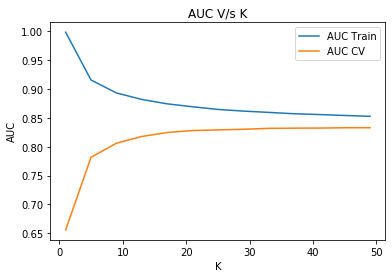

In [26]:
# Importing the data
X = preprocessed_reviews
y = np.array(final['Score'])

# Spliting the data into train,CV, test 
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size=0.3)
# CountVectorizer for train, CV, test data
count_vect = CountVectorizer()
final_Xtr = count_vect.fit_transform(X_tr) # We use fit_transform() for train and transform() for test and cv
final_Xcv = count_vect.transform(X_cv)
final_Xtest = count_vect.transform(X_test)

# Implementation 
auc_train = []
auc_cv = []
K = list(range(1,50,4))

for i in tqdm(K):
    knn = KNeighborsClassifier(n_neighbors = i, weights = 'uniform',algorithm = 'brute',leaf_size = 30, p = 2, metric = 'cosine')
    knn.fit(final_Xtr,y_tr)
    
    pred_tr = knn.predict_proba(final_Xtr)[:,1]
    auc_train.append(roc_auc_score(y_tr,pred_tr))
    
    pred_cv = knn.predict_proba(final_Xcv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred_cv))

# Graph between AUC V/s K
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(K,auc_train, label = 'AUC Train')
ax.plot(K,auc_cv, label = 'AUC CV')

plt.title('AUC V/s K')
plt.xlabel('K')
plt.ylabel('AUC')

plt.legend()
plt.show()

    



In [27]:
auc_cv

[0.6687328422112668,
 0.7819664457290837,
 0.8092525981723624,
 0.8212833919229714,
 0.8263868264805181,
 0.8300161553427187,
 0.8315883652832945,
 0.8337156262642682,
 0.8340511724948403,
 0.834790107095282,
 0.8359852732047518,
 0.8371830803707393,
 0.8382083825285133]

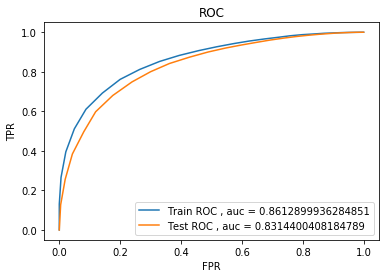

In [30]:
# ROC Curve for K = 30 seens best hyperparameter
knn = KNeighborsClassifier(n_neighbors = 30, weights = 'uniform', algorithm = 'brute', leaf_size = 30, p = 2, metric = 'cosine')
knn.fit(final_Xtr,y_tr)

pred_tr = knn.predict_proba(final_Xtr)[:,1]
fpr_tr,tpr_tr,thresholds_tr = metrics.roc_curve(y_tr,pred_tr)

pred_test = knn.predict_proba(final_Xtest)[:,1]
fpr_test,tpr_test,thresholds_test = metrics.roc_curve(y_test,pred_test)

# Plot the Graph between TPR AND FPR
fig = plt.figure()
ax = plt.subplot()
ax.plot(fpr_tr,tpr_tr,label = 'Train ROC , auc = '+str(roc_auc_score(y_tr,pred_tr)))
ax.plot(fpr_test,tpr_test,label = 'Test ROC , auc = '+str(roc_auc_score(y_test,pred_test)))

plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')

ax.legend()
plt.show()

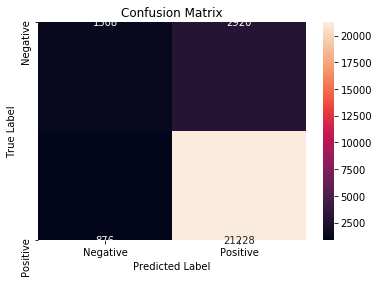

In [29]:
# Confusion Metrix
knn = KNeighborsClassifier(n_neighbors = 30, weights = 'uniform',algorithm = 'brute', leaf_size = 30,p = 2, metric = 'cosine')
knn.fit(final_Xtr,y_tr)

predict_test = knn.predict(final_Xtest)

conf_mat = confusion_matrix(y_test, predict_test)
class_label = ["Negative", "Positive"]

df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)

sns.heatmap(df,annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### [5.1.2] Applying KNN brute force on TFIDF

100%|██████████| 13/13 [31:40<00:00, 146.21s/it]


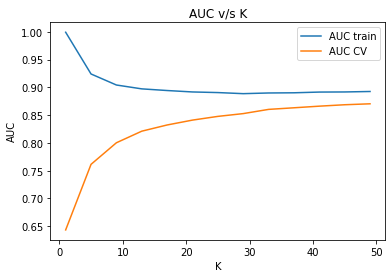

In [30]:
# Preparing the data
X = preprocessed_reviews
y = np.array(final['Score'])

# Spliting the data into train, cv and test
X_1, X_test, y_1, y_test = train_test_split(X,y, test_size = .3,random_state = 0)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1,y_1, test_size = 0.3)

# Tfidf
tf_idf_vect = TfidfVectorizer(ngram_range = (1,2), min_df = 10)

final_Xtr = tf_idf_vect.fit_transform(X_tr)
final_Xcv = tf_idf_vect.transform(X_cv)
final_Xtest = tf_idf_vect.transform(X_test)

# KNN
auc_cv = []
auc_train = []
K = list(range(1,50,4))

for i in tqdm(K):
    knn = KNeighborsClassifier(n_neighbors = i, weights = 'uniform', algorithm = 'brute',leaf_size = 30,p = 2, metric = 'cosine')
    knn.fit(final_Xtr, y_tr)
    
    pred_tr = knn.predict_proba(final_Xtr)[:,1]
    auc_train.append(roc_auc_score(y_tr, pred_tr))
    
    pred_cv = knn.predict_proba(final_Xcv)[:,1]
    auc_cv.append(roc_auc_score(y_cv, pred_cv))

# Graph between AUC vs K
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(K, auc_train, label= 'AUC train')
ax.plot(K, auc_cv, label = 'AUC CV')

plt.title('AUC v/s K')
plt.xlabel('K')
plt.ylabel('AUC')

ax.legend()
plt.show()

In [31]:
auc_cv

[0.643406966864911,
 0.7613796203324665,
 0.8002108060211288,
 0.8210522064313484,
 0.8322152708049054,
 0.840979023454597,
 0.8476675849403121,
 0.8526734206980596,
 0.8602587042901402,
 0.8631443255837903,
 0.8660602842357303,
 0.8686114329359869,
 0.8703135968864516]

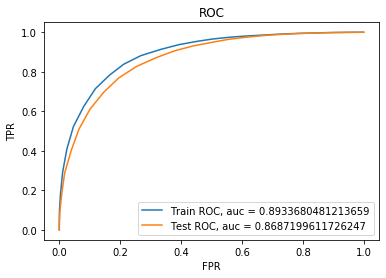

In [42]:
# ROC curve for K = 49 seen best hyperparameter
knn = KNeighborsClassifier(n_neighbors = 49, weights = 'uniform', algorithm = 'brute', leaf_size = 30, p = 2, metric = 'cosine')
knn.fit(final_Xtr, y_tr)

pred_tr = knn.predict_proba(final_Xtr)[:,1]
fpr_tr, tpr_tr, thresholds_tr = metrics.roc_curve(y_tr, pred_tr)

pred_test = knn.predict_proba(final_Xtest)[:,1]
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, pred_test)

# Graph between TPR AND FPR
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(fpr_tr, tpr_tr,label = 'Train ROC, auc = '+str(roc_auc_score(y_tr, pred_tr)))
ax.plot(fpr_test, tpr_test,label = 'Test ROC, auc = '+str(roc_auc_score(y_test, pred_test)))

plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")

ax.legend()
plt.show()

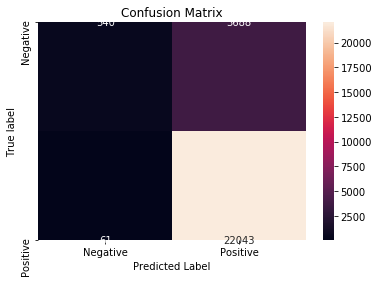

In [43]:
# Confusion matrix
knn = KNeighborsClassifier(n_neighbors = 49, weights = 'uniform', algorithm = 'brute', leaf_size = 30, p = 2, metric = 'cosine')
knn.fit(final_Xtr, y_tr)

predict_test = knn.predict(final_Xtest)

conf_mat = confusion_matrix(y_test, predict_test)
class_label = ["Negative", "Positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)

sns.heatmap(df, annot = True, fmt = "d")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True label")
plt.show()

### [5.1.3] Applying KNN brute force on AVG W2V

In [32]:
# Preparing the data
X = preprocessed_reviews
y = np.array(final['Score'])

# Spliting the data into Train, CV and Test
X_1, X_test, y_1, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size = 0.3)

# Word2Vec

list_of_sentance_tr = []

for sentance in X_tr:
    list_of_sentance_tr.append(sentance.split())
w2v_model = Word2Vec(list_of_sentance_tr, min_count = 5, size = 50, workers = 4)
w2v_words = list(w2v_model.wv.vocab)


def word2Vec(X):
    list_of_sentance = []
    
    for sentance in X:
        list_of_sentance.append(sentance.split())
    
    sent_vectors = []
    
    for sent in tqdm(list_of_sentance):
        sent_vec = np.zeros(50)
        cnt_words = 0
        
        for word in sent:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        
        if cnt_words != 0:
            sent_vec /= cnt_words
        
        sent_vectors.append(sent_vec)
    
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    
    return sent_vectors

final_Xtr = word2Vec(X_tr)    
final_Xcv = word2Vec(X_cv)    
final_Xtest = word2Vec(X_test)    

  0%|          | 75/18433 [00:00<01:21, 226.25it/s]

43008
50


  0%|          | 0/26332 [00:00<?, ?it/s]

18433
50


100%|██████████| 26332/26332 [01:29<00:00, 293.56it/s]

26332
50


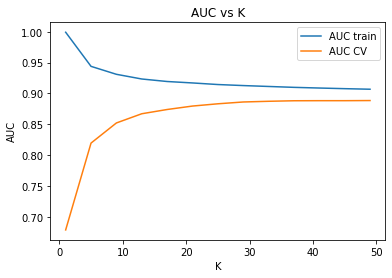

In [45]:
# KNN
auc_train = []
auc_cv = []
K = list(range(1,50,4))

for i in tqdm(K):
    knn = KNeighborsClassifier(n_neighbors = i, weights = 'uniform', algorithm = 'brute', leaf_size = 30, p = 2,metric = 'cosine')
    knn.fit(final_Xtr,y_tr)
    
    pred_tr = knn.predict_proba(final_Xtr)[:,1]
    auc_train.append(roc_auc_score(y_tr,pred_tr))
    
    pred_cv = knn.predict_proba(final_Xcv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred_cv))
    

# Graph between AUC v/s K
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(K,auc_train, label = "AUC train")
ax.plot(K,auc_cv, label = "AUC CV")

plt.title('AUC vs K')
plt.xlabel('K')
plt.ylabel('AUC')

ax.legend()
plt.show()
    

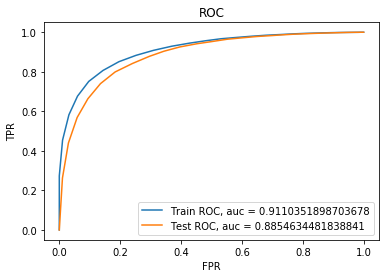

In [33]:
# ROC curve for K = 30 seen best hyperparameter
knn = KNeighborsClassifier(n_neighbors = 30, weights = 'uniform', algorithm = 'brute', leaf_size = 30, p = 2, metric = 'cosine')
knn.fit(final_Xtr, y_tr)

pred_tr = knn.predict_proba(final_Xtr)[:,1]
fpr_tr, tpr_tr, thresholds_tr = metrics.roc_curve(y_tr, pred_tr)

pred_test = knn.predict_proba(final_Xtest)[:,1]
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, pred_test)

# Graph between TPR AND FPR
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(fpr_tr, tpr_tr,label = 'Train ROC, auc = '+str(roc_auc_score(y_tr, pred_tr)))
ax.plot(fpr_test, tpr_test,label = 'Test ROC, auc = '+str(roc_auc_score(y_test, pred_test)))

plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")

ax.legend()
plt.show()

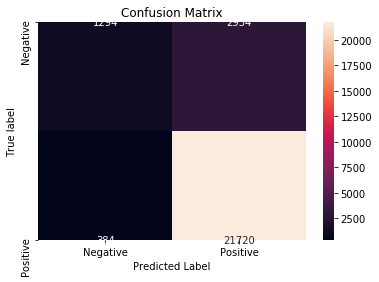

In [47]:
# Confusion Matrix
knn = KNeighborsClassifier(n_neighbors = 30, weights = 'uniform', algorithm = 'brute', leaf_size = 30, p = 2, metric = 'cosine')
knn.fit(final_Xtr, y_tr)

predict_test = knn.predict(final_Xtest)

conf_mat = confusion_matrix(y_test, predict_test)
class_label = ["Negative", "Positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)

sns.heatmap(df, annot = True, fmt = "d")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True label")
plt.show()

### [5.1.4] Applying KNN brute force on TFIDF W2V

In [34]:
# Preparing the data
X = preprocessed_reviews
y = np.array(final['Score'])

# Spliting the data
X_1, X_test, y_1, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
X_tr, X_cv, y_tr,y_cv = train_test_split(X_1,y_1, test_size = 0.3)


list_of_sentance_train = []
for sentance in X_tr:
    list_of_sentance_train.append(sentance.split())

w2v_model  = Word2Vec(list_of_sentance_train, min_count = 5, size = 50, workers = 4)
w2v_words = list(w2v_model.wv.vocab)

tf_idf_vect = TfidfVectorizer(ngram_range = (1,2), min_df = 10, max_features = 500)
tf_idf_matrix = tf_idf_vect.fit_transform(X_tr)

tfidf_feat = tf_idf_vect.get_feature_names()
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

# TFIDF W2V Function
def tfidf_W2V(X):
    list_of_sentance = []
    
    for sentance in X:
        list_of_sentance.append(sentance.split())
    
    tfidf_sent_vectors = []
    row = 0
    
    for sent in tqdm(list_of_sentance):
        sent_vec = np.zeros(50)
        weight_sum = 0
        
        for word in sent:
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum  += tf_idf
        
        if weight_sum != 0:
            sent_vec /= weight_sum
        
        tfidf_sent_vectors.append(sent_vec)
        row +=1
    print(len(tfidf_sent_vectors))
    print(len(tfidf_sent_vectors[0]))
    
    return tfidf_sent_vectors

final_Xtr = tfidf_W2V(X_tr)
final_Xcv = tfidf_W2V(X_cv)
final_Xtest = tfidf_W2V(X_test)

  0%|          | 70/18433 [00:00<00:53, 343.72it/s]

43008
50


100%|██████████| 18433/18433 [01:01<00:00, 300.23it/s]


18433
50


100%|██████████| 26332/26332 [01:20<00:00, 328.87it/s]

26332
50


100%|██████████| 13/13 [12:53<00:00, 59.51s/it]


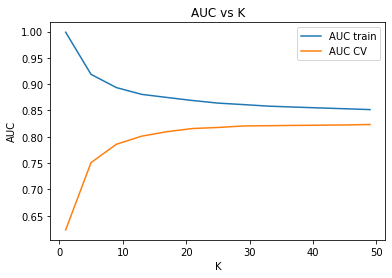

In [49]:
# KNN
auc_train = []
auc_cv = []
K = list(range(1,50,4))

for i in tqdm(K):
    knn = KNeighborsClassifier(n_neighbors = i, weights = 'uniform', algorithm = 'brute', leaf_size = 30, p = 2,metric = 'cosine')
    knn.fit(final_Xtr,y_tr)
    
    pred_tr = knn.predict_proba(final_Xtr)[:,1]
    auc_train.append(roc_auc_score(y_tr,pred_tr))
    
    pred_cv = knn.predict_proba(final_Xcv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred_cv))
    

# Graph between AUC v/s K
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(K,auc_train, label = "AUC train")
ax.plot(K,auc_cv, label = "AUC CV")

plt.title('AUC vs K')
plt.xlabel('K')
plt.ylabel('AUC')

ax.legend()
plt.show()
    

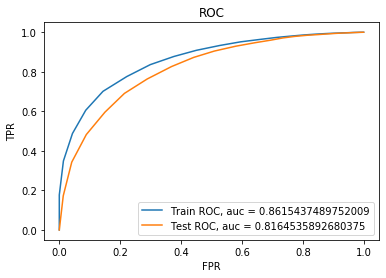

In [35]:
# ROC curve for K = 30 seen best hyperparameter
knn = KNeighborsClassifier(n_neighbors = 30, weights = 'uniform', algorithm = 'brute', leaf_size = 30, p = 2, metric = 'cosine')
knn.fit(final_Xtr, y_tr)

pred_tr = knn.predict_proba(final_Xtr)[:,1]
fpr_tr, tpr_tr, thresholds_tr = metrics.roc_curve(y_tr, pred_tr)

pred_test = knn.predict_proba(final_Xtest)[:,1]
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, pred_test)

# Graph between TPR AND FPR
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(fpr_tr, tpr_tr,label = 'Train ROC, auc = '+str(roc_auc_score(y_tr, pred_tr)))
ax.plot(fpr_test, tpr_test,label = 'Test ROC, auc = '+str(roc_auc_score(y_test, pred_test)))

plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")

ax.legend()
plt.show()

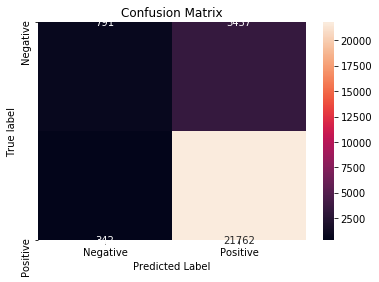

In [36]:
# Confusion Matrix
knn = KNeighborsClassifier(n_neighbors = 30, weights = 'uniform', algorithm = 'brute', leaf_size = 30, p = 2, metric = 'cosine')
knn.fit(final_Xtr, y_tr)

predict_test = knn.predict(final_Xtest)

conf_mat = confusion_matrix(y_test, predict_test)
class_label = ["Negative", "Positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)

sns.heatmap(df, annot = True, fmt = "d")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True label")
plt.show()

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW

100%|██████████| 13/13 [1:00:38<00:00, 279.88s/it]


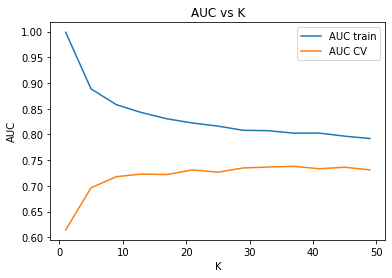

In [52]:
# Preparing the data
X = preprocessed_reviews[:30000]
y = np.array(final['Score'])[:30000]

# Spliting the data
X_1, X_test, y_1, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
X_tr, X_cv, y_tr,y_cv = train_test_split(X_1,y_1, test_size = 0.3)

# Count Vectorizer for train, cv and test
count_vect  = CountVectorizer(min_df = 10, max_features = 500) # fit_transform is used for train
final_Xtr = count_vect.fit_transform(X_tr).toarray()
final_Xcv = count_vect.transform(X_cv).toarray()
final_Xtest = count_vect.transform(X_test).toarray()

# KNN
auc_cv = []
auc_train = []
K = list(range(1,50,4))
for i in tqdm(K):
    knn = KNeighborsClassifier(n_neighbors = i,weights = "uniform", algorithm = "kd_tree")
    knn.fit(final_Xtr,y_tr)
    
    pred_Xtr = knn.predict_proba(final_Xtr)[:,1]
    auc_train.append(roc_auc_score(y_tr,pred_Xtr))
    
    pred_Xcv = knn.predict_proba(final_Xcv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred_Xcv))
    
# Graph between AUC and K

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(K,auc_train, label = "AUC train")
ax.plot(K,auc_cv, label = "AUC CV")

plt.title('AUC vs K')
plt.xlabel('K')
plt.ylabel('AUC')

ax.legend()
plt.show()
    


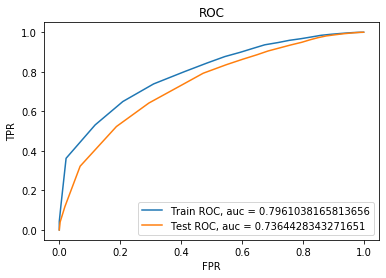

In [38]:
# ROC curve for K = 30 seen best hyperparameter
knn = KNeighborsClassifier(n_neighbors = 30, weights = 'uniform', algorithm = 'kd_tree')
knn.fit(final_Xtr, y_tr)

pred_tr = knn.predict_proba(final_Xtr)[:,1]
fpr_tr, tpr_tr, thresholds_tr = metrics.roc_curve(y_tr, pred_tr)

pred_test = knn.predict_proba(final_Xtest)[:,1]
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, pred_test)

# Graph between TPR AND FPR
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(fpr_tr, tpr_tr,label = 'Train ROC, auc = '+str(roc_auc_score(y_tr, pred_tr)))
ax.plot(fpr_test, tpr_test,label = 'Test ROC, auc = '+str(roc_auc_score(y_test, pred_test)))

plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")

ax.legend()
plt.show()

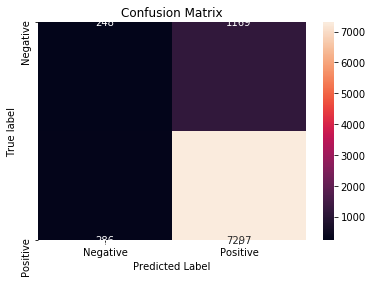

In [39]:
# Confusion Matrix
knn = KNeighborsClassifier(n_neighbors = 30, weights = 'uniform', algorithm = 'kd_tree')
knn.fit(final_Xtr, y_tr)

predict_test = knn.predict(final_Xtest)

conf_mat = confusion_matrix(y_test, predict_test)
class_label = ["Negative", "Positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)

sns.heatmap(df, annot = True, fmt = "d")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True label")
plt.show()

### [5.2.2] Applying KNN kd-tree on TFIDF

100%|██████████| 13/13 [07:21<00:00, 33.95s/it]


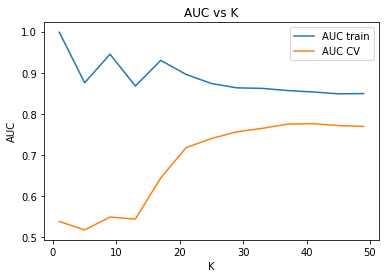

In [55]:
# Preparing the dat
X = preprocessed_reviews[:10000]
y = np.array(final['Score'])[:10000]

# Spliting data into train, CV and test 
X_1, X_test, y_1, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
X_tr, X_cv, y_tr,y_cv = train_test_split(X_1,y_1, test_size = 0.3)

# TFIDF
tf_idf_vect = TfidfVectorizer(ngram_range = (1,2), min_df  = 10, max_features = 500)
final_Xtr = tf_idf_vect.fit_transform(X_tr).toarray()
final_Xcv = tf_idf_vect.transform(X_cv).toarray()
final_Xtest = tf_idf_vect.transform(X_test).toarray()

# KNN
auc_train = []
auc_cv = []
K = list(range(1,50,4))

for i in tqdm(K):
    knn = KNeighborsClassifier(n_neighbors = i, weights = 'uniform', algorithm = 'kd_tree')
    knn.fit(final_Xtr,y_tr)
    
    pred_tr = knn.predict_proba(final_Xtr)[:,1]
    auc_train.append(roc_auc_score(y_tr,pred_tr))
    
    pred_cv = knn.predict_proba(final_Xcv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred_cv))
    

# Graph between AUC v/s K
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(K,auc_train, label = "AUC train")
ax.plot(K,auc_cv, label = "AUC CV")

plt.title('AUC vs K')
plt.xlabel('K')
plt.ylabel('AUC')

ax.legend()
plt.show()


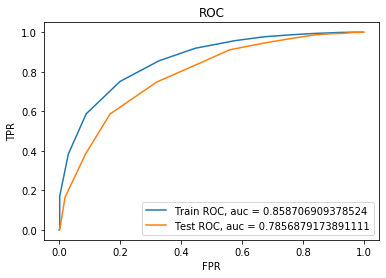

In [41]:
# ROC curve for K = 37 seen best hyperparameter
knn = KNeighborsClassifier(n_neighbors = 37, weights = 'uniform', algorithm = 'kd_tree')
knn.fit(final_Xtr, y_tr)

pred_tr = knn.predict_proba(final_Xtr)[:,1]
fpr_tr, tpr_tr, thresholds_tr = metrics.roc_curve(y_tr, pred_tr)

pred_test = knn.predict_proba(final_Xtest)[:,1]
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, pred_test)

# Graph between TPR AND FPR
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(fpr_tr, tpr_tr,label = 'Train ROC, auc = '+str(roc_auc_score(y_tr, pred_tr)))
ax.plot(fpr_test, tpr_test,label = 'Test ROC, auc = '+str(roc_auc_score(y_test, pred_test)))

plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")

ax.legend()
plt.show()

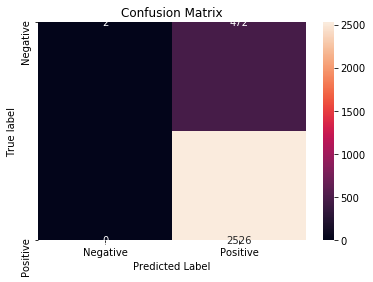

In [42]:
# Confusion Matrix
knn = KNeighborsClassifier(n_neighbors = 37, weights = 'uniform', algorithm = 'kd_tree')
knn.fit(final_Xtr, y_tr)

predict_test = knn.predict(final_Xtest)

conf_mat = confusion_matrix(y_test, predict_test)
class_label = ["Negative", "Positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)

sns.heatmap(df, annot = True, fmt = "d")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True label")
plt.show()

### [5.2.3] Applying KNN kd-tree on AVG W2V

In [44]:
# Preparing the data
X = preprocessed_reviews[:30000]
y = np.array(final['Score'])[:30000]

# Spliting the data into Train, CV and Test
X_1, X_test, y_1, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
X_tr, X_cv, y_tr, y_cv = train_test_split(X_1, y_1, test_size = 0.3)

# Word2Vec

list_of_sentance_tr = []

for sentance in X_tr:
    list_of_sentance_tr.append(sentance.split())
w2v_model = Word2Vec(list_of_sentance_tr, min_count = 5, size = 50, workers = 4)
w2v_words = list(w2v_model.wv.vocab)


def word2Vec(X):
    list_of_sentance = []
    
    for sentance in X:
        list_of_sentance.append(sentance.split())
    
    sent_vectors = []
    
    for sent in tqdm(list_of_sentance):
        sent_vec = np.zeros(50)
        cnt_words = 0
        
        for word in sent:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        
        if cnt_words != 0:
            sent_vec /= cnt_words
        
        sent_vectors.append(sent_vec)
    
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    
    return sent_vectors

final_Xtr = word2Vec(X_tr)    
final_Xcv = word2Vec(X_cv)    
final_Xtest = word2Vec(X_test)    

  2%|▏         | 122/6300 [00:00<00:10, 594.41it/s]

14700
50


  1%|          | 68/9000 [00:00<00:13, 677.58it/s]

6300
50


100%|██████████| 9000/9000 [00:13<00:00, 678.15it/s]

9000
50


100%|██████████| 13/13 [06:26<00:00, 29.75s/it]


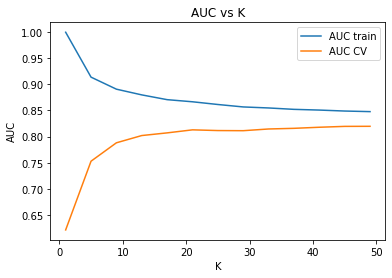

In [59]:
# KNN
auc_train = []
auc_cv = []
K = list(range(1,50,4))

for i in tqdm(K):
    knn = KNeighborsClassifier(n_neighbors = i, weights = 'uniform', algorithm = 'kd_tree')
    knn.fit(final_Xtr,y_tr)
    
    pred_tr = knn.predict_proba(final_Xtr)[:,1]
    auc_train.append(roc_auc_score(y_tr,pred_tr))
    
    pred_cv = knn.predict_proba(final_Xcv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred_cv))
    

# Graph between AUC v/s K
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(K,auc_train, label = "AUC train")
ax.plot(K,auc_cv, label = "AUC CV")

plt.title('AUC vs K')
plt.xlabel('K')
plt.ylabel('AUC')

ax.legend()
plt.show()
    

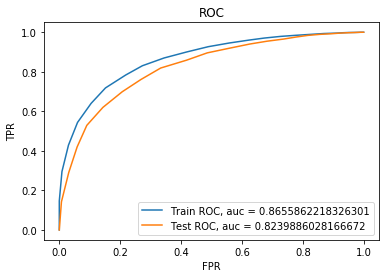

In [45]:
# ROC curve for K = 33 seen best hyperparameter
knn = KNeighborsClassifier(n_neighbors = 33, weights = 'uniform', algorithm = 'kd_tree')
knn.fit(final_Xtr, y_tr)

pred_tr = knn.predict_proba(final_Xtr)[:,1]
fpr_tr, tpr_tr, thresholds_tr = metrics.roc_curve(y_tr, pred_tr)

pred_test = knn.predict_proba(final_Xtest)[:,1]
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, pred_test)

# Graph between TPR AND FPR
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(fpr_tr, tpr_tr,label = 'Train ROC, auc = '+str(roc_auc_score(y_tr, pred_tr)))
ax.plot(fpr_test, tpr_test,label = 'Test ROC, auc = '+str(roc_auc_score(y_test, pred_test)))

plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")

ax.legend()
plt.show()

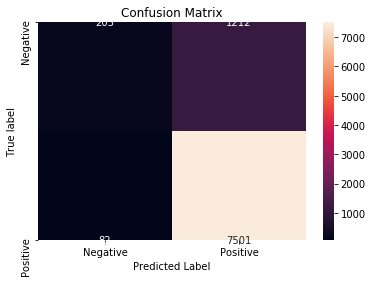

In [46]:
# Confusion Matrix
knn = KNeighborsClassifier(n_neighbors = 33, weights = 'uniform', algorithm = 'kd_tree')
knn.fit(final_Xtr, y_tr)

predict_test = knn.predict(final_Xtest)

conf_mat = confusion_matrix(y_test, predict_test)
class_label = ["Negative", "Positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)

sns.heatmap(df, annot = True, fmt = "d")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True label")
plt.show()

### [5.2.4] Applying KNN kd-tree on TFIDF W2V

In [47]:
# Preparing the data
X = preprocessed_reviews[:30000]
y = np.array(final['Score'])[:30000]

# Spliting the data
X_1, X_test, y_1, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
X_tr, X_cv, y_tr,y_cv = train_test_split(X_1,y_1, test_size = 0.3)


list_of_sentance_train = []
for sentance in X_tr:
    list_of_sentance_train.append(sentance.split())

w2v_model  = Word2Vec(list_of_sentance_train, min_count = 5, size = 50, workers = 4)
w2v_words = list(w2v_model.wv.vocab)

tf_idf_vect = TfidfVectorizer(ngram_range = (1,2), min_df = 10, max_features = 500)
tf_idf_matrix = tf_idf_vect.fit_transform(X_tr)

tfidf_feat = tf_idf_vect.get_feature_names()
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

# TFIDF W2V Function
def tfidf_W2V(X):
    list_of_sentance = []
    
    for sentance in X:
        list_of_sentance.append(sentance.split())
    
    tfidf_sent_vectors = []
    row = 0
    
    for sent in tqdm(list_of_sentance):
        sent_vec = np.zeros(50)
        weight_sum = 0
        
        for word in sent:
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum  += tf_idf
        
        if weight_sum != 0:
            sent_vec /= weight_sum
        
        tfidf_sent_vectors.append(sent_vec)
        row +=1
    print(len(tfidf_sent_vectors))
    print(len(tfidf_sent_vectors[0]))
    
    return tfidf_sent_vectors

final_Xtr = tfidf_W2V(X_tr)
final_Xcv = tfidf_W2V(X_cv)
final_Xtest = tfidf_W2V(X_test)

  2%|▏         | 117/6300 [00:00<00:11, 532.35it/s]

14700
50


  1%|          | 91/9000 [00:00<00:19, 447.17it/s]

6300
50


100%|██████████| 9000/9000 [00:17<00:00, 521.72it/s]

9000
50


100%|██████████| 13/13 [05:31<00:00, 25.53s/it]


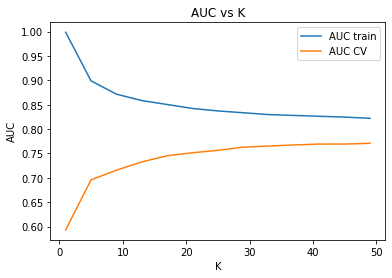

In [63]:
# KNN
auc_train = []
auc_cv = []
K = list(range(1,50,4))

for i in tqdm(K):
    knn = KNeighborsClassifier(n_neighbors = i, weights = 'uniform', algorithm = 'kd_tree')
    knn.fit(final_Xtr,y_tr)
    
    pred_tr = knn.predict_proba(final_Xtr)[:,1]
    auc_train.append(roc_auc_score(y_tr,pred_tr))
    
    pred_cv = knn.predict_proba(final_Xcv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred_cv))
    

# Graph between AUC v/s K
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(K,auc_train, label = "AUC train")
ax.plot(K,auc_cv, label = "AUC CV")

plt.title('AUC vs K')
plt.xlabel('K')
plt.ylabel('AUC')

ax.legend()
plt.show()
    

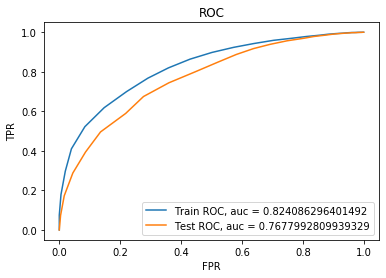

In [48]:
# ROC curve for K = 40 seen best hyperparameter
knn = KNeighborsClassifier(n_neighbors = 40, weights = 'uniform', algorithm = 'kd_tree')
knn.fit(final_Xtr, y_tr)

pred_tr = knn.predict_proba(final_Xtr)[:,1]
fpr_tr, tpr_tr, thresholds_tr = metrics.roc_curve(y_tr, pred_tr)

pred_test = knn.predict_proba(final_Xtest)[:,1]
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, pred_test)

# Graph between TPR AND FPR
fig = plt.figure()
ax = plt.subplot(111)

ax.plot(fpr_tr, tpr_tr,label = 'Train ROC, auc = '+str(roc_auc_score(y_tr, pred_tr)))
ax.plot(fpr_test, tpr_test,label = 'Test ROC, auc = '+str(roc_auc_score(y_test, pred_test)))

plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")

ax.legend()
plt.show()

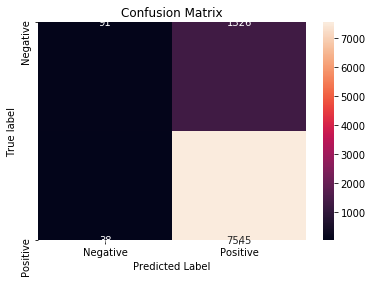

In [49]:
# Confusion Matrix
knn = KNeighborsClassifier(n_neighbors = 40, weights = 'uniform', algorithm = 'kd_tree')
knn.fit(final_Xtr, y_tr)

predict_test = knn.predict(final_Xtest)

conf_mat = confusion_matrix(y_test, predict_test)
class_label = ["Negative", "Positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)

sns.heatmap(df, annot = True, fmt = "d")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True label")
plt.show()

# [6] Conclusions

In [54]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Vectirizer","Model", "Hyper parameter(K)","AUC" ]
x.field_names = ["Vectorizer", "Model", "Hyperameter", "AUC"]
x.add_row(["BOW","Brute",30,0.834])
x.add_row(["TFIDF","Brute",49,0.869])
x.add_row(["AwgW2V","Brute",30,0.885])
x.add_row(["TFIDF W2V","Brute",30,0.816])
x.add_row(["BOW","k_d tree",30,0.736])
x.add_row(["TFIDF","k_d tree",37,0.786])
x.add_row(["AwgW2V","k_d tree",33,0.824])
x.add_row(["TFIDF W2V","k_d tree",40,0.768])
print(x)

+------------+----------+-------------+-------+
| Vectorizer |  Model   | Hyperameter |  AUC  |
+------------+----------+-------------+-------+
|    BOW     |  Brute   |      30     | 0.834 |
|   TFIDF    |  Brute   |      49     | 0.869 |
|   AwgW2V   |  Brute   |      30     | 0.885 |
| TFIDF W2V  |  Brute   |      30     | 0.816 |
|    BOW     | k_d tree |      30     | 0.736 |
|   TFIDF    | k_d tree |      37     | 0.786 |
|   AwgW2V   | k_d tree |      33     | 0.824 |
| TFIDF W2V  | k_d tree |      40     | 0.768 |
+------------+----------+-------------+-------+
